## Link Video

### https://drive.google.com/drive/folders/1v1En2xqdBHOVpnJODKBRemMxlZTXfk8y?usp=sharing

# **2. Image Denoising using Autoencoder**

In [21]:
# # pip install tensorflow-macos tensorflow-metal
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(tf.config.list_physical_devices('GPU'))

## Import Library

In [70]:
from zipfile import ZipFile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

## Read File Via Zip

In [23]:
zip_path = '/content/B_23.zip'
extract_path = '/content/B_23'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

def loadFile(folder_path='/content/B_23', size=(100, 100)):
    images = []
    valid_extensions = ('.jpg', '.png', '.jpeg')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(valid_extensions):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            images.append(img)

    return np.array(images)

real_images = loadFile()
print("Images loaded:", real_images.shape)

Images loaded: (0,)


In [24]:
real_images = loadFile('B_23/B_23', size=(100, 100))

## EDA

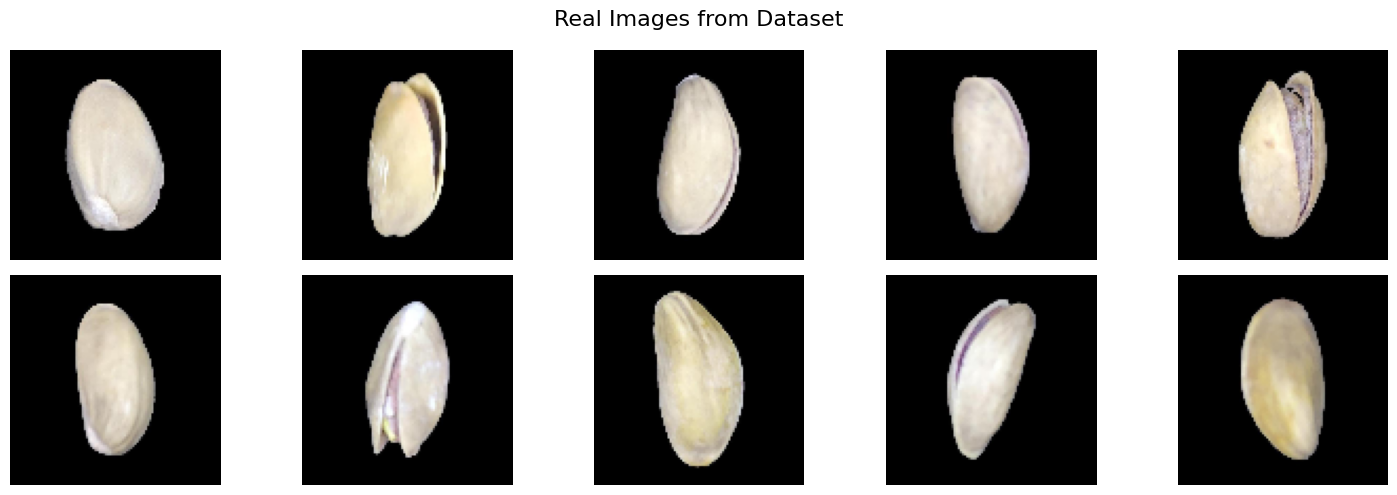

In [25]:
def plot_real_images(images, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i]
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)

        plt.imshow(img)
        plt.axis('off')

    plt.suptitle('Real Images from Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_real_images(real_images, num_images=10)

In [26]:
for idx, img in enumerate(real_images):
    if img.shape != (100, 100, 3):
        print(f'Image at index {idx} has shape: {img.shape}')

all image shapes is already 100 x 100

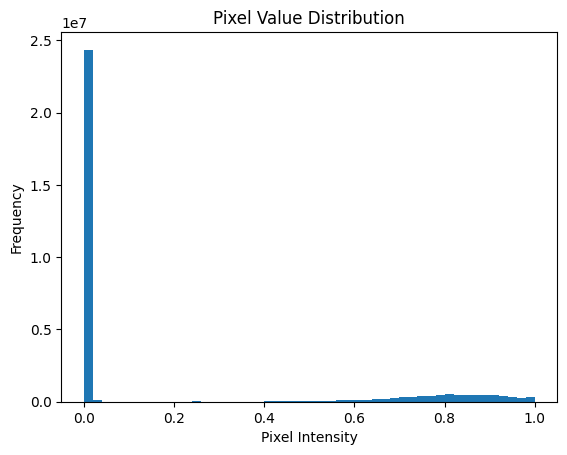

In [27]:
plt.hist(real_images.flatten(), bins=50)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Most areas of the images are dominated by dark or black pixels, as seen in the six images above. Meanwhile, the range of 0.7–1.0 indicates that a small portion of the objects has relatively high brightness levels.

In [28]:
print(f'Min pixel value: {real_images.min()}')
print(f'Max pixel value: {real_images.max()}')
print(f'Mean pixel value: {real_images.mean()}')


Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.1899762600660324


0.19 means most pixels are on the darker side

In [29]:
for idx, img in enumerate(real_images):
    if np.max(img) == 0:
        print(f'Image at index {idx} is completely black (empty).')


That means there are no images that are completely black or empty.

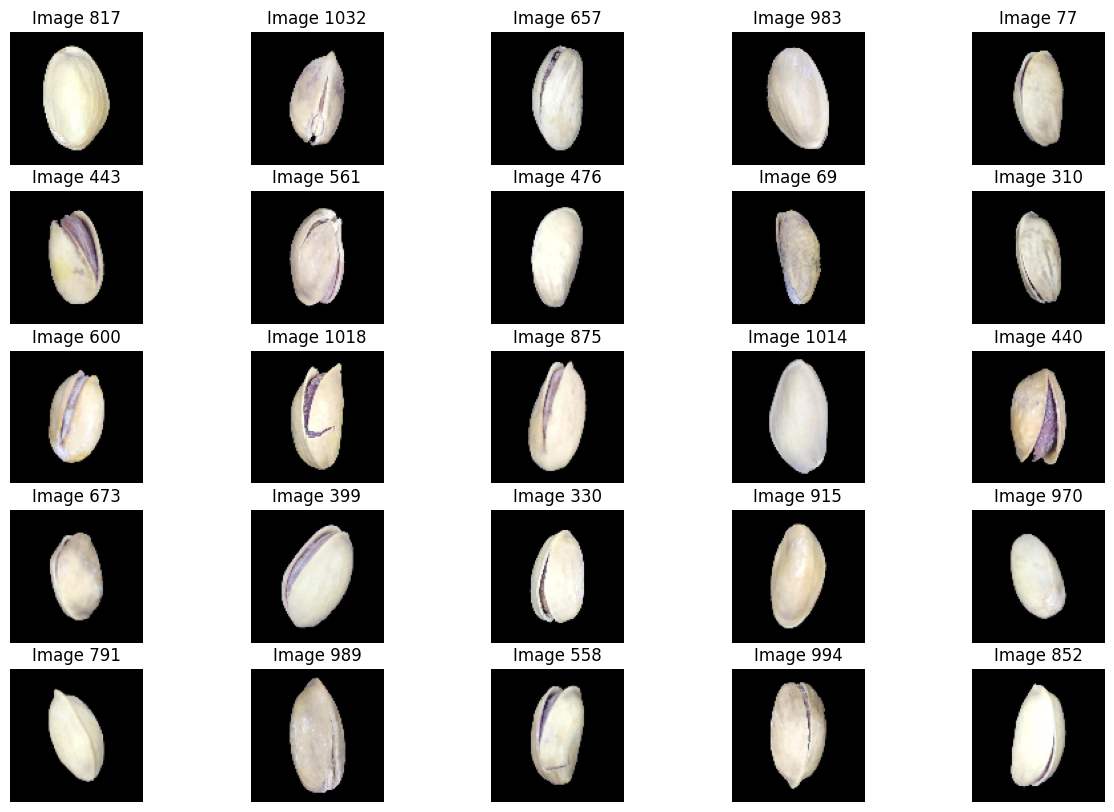

In [30]:
plt.figure(figsize=(15, 10))
for i in range(25):
    idx = np.random.randint(0, real_images.shape[0])
    plt.subplot(5, 5, i+1)
    plt.imshow(real_images[idx])
    plt.title(f'Image {idx}')
    plt.axis('off')
plt.show()

The dataset has a fairly diverse pattern, ensuring that the model does not overfit to a single pistachio pattern.

In [31]:
threshold = 0.05
background_ratio = (real_images < threshold).sum() / np.prod(real_images.shape)
print(f'Background pixel ratio: {background_ratio:.2%}')

Background pixel ratio: 75.94%


Black backgrounds are still considered normal.

In [32]:
r_mean = real_images[:,:,:,0].mean()
g_mean = real_images[:,:,:,1].mean()
b_mean = real_images[:,:,:,2].mean()
print(f'R mean: {r_mean:.4f}, G mean: {g_mean:.4f}, B mean: {b_mean:.4f}')

R mean: 0.2003, G mean: 0.1912, B mean: 0.1785


Overall, the color distribution is more or less consistent with what we observe in the plot.

## Split Data

In [33]:
X_train, X_temp = train_test_split(real_images, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print(f'Training set: {X_train.shape}')
print(f'Validation set: {X_val.shape}')
print(f'Testing set: {X_test.shape}')

Training set: (859, 100, 100, 3)
Validation set: (107, 100, 100, 3)
Testing set: (108, 100, 100, 3)


## Adding Noise Using Gaussian

In [34]:
noise_factor = 0.1
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_val_noisy = X_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Clip agar tetap di range [0, 1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_val_noisy = np.clip(X_val_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

We added noise to the train, validation, and test sets according to the given configuration—using a normal (Gaussian) distribution with a mean of 0.0 and a standard deviation of 0.1. Then, we applied clipping to ensure the pixel values remain within the range [0, 1].

## Base Model Autoencoder

In [35]:
input_img = Input(shape=(100, 100, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

## Fit Base Model

In [36]:
history = autoencoder.fit(
    X_train_noisy, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val_noisy, X_val)
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.1225 - val_loss: 0.0104
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.

## Evaluate Base Model

In [37]:
def calculate_ssim(y_true, y_pred):
    scores = []
    for i in range(len(y_true)):
        score = ssim(y_true[i], y_pred[i], data_range=1.0, channel_axis=-1)
        scores.append(score)
    return np.mean(scores)

X_test_pred = autoencoder.predict(X_test_noisy)
baseline_ssim = calculate_ssim(X_test, X_test_pred)
print(f'Baseline Model SSIM: {baseline_ssim:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Baseline Model SSIM: 0.9448


## Visualisasi Hasil Base Model

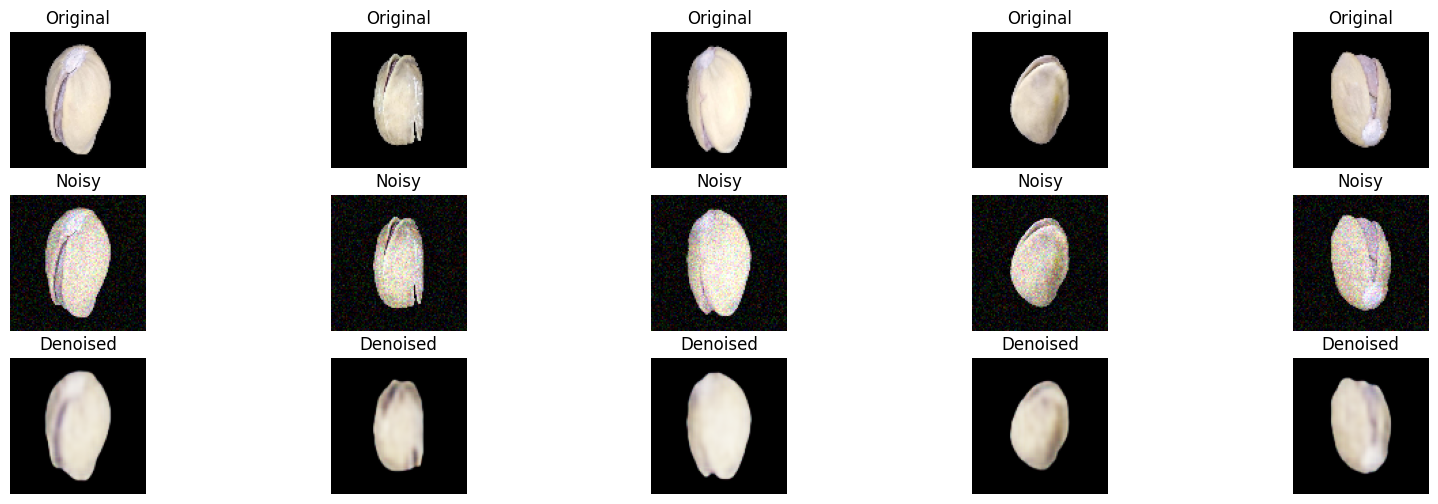

In [38]:
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(X_test_pred[i])
    plt.title("Denoised")
    plt.axis("off")
plt.show()

## Modified Model

In [85]:
input_img = Input(shape=(100, 100, 3))

x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_mod = Model(input_img, decoded)
autoencoder_mod.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')
autoencoder_mod.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_40 (UpSampling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_41 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

## Fit Modified Model

In [86]:
history_simple = autoencoder_mod.fit(
    X_train_noisy, X_train,
    epochs=50,
    batch_size=4,
    shuffle=True,
    validation_data=(X_val_noisy, X_val)
)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0821 - val_loss: 0.0039
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 12/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

## Evaluate Modified Model

In [87]:
X_test_pred_simple = autoencoder_mod.predict(X_test_noisy)
simple_ssim = calculate_ssim(X_test, X_test_pred_simple)
print(f'Simple Model SSIM: {simple_ssim:.4f}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
Simple Model SSIM: 0.9574
